In [32]:
!pip install yfinance
!pip install plotly

     |████████████████████████████████| 62 kB 369 kB/s 
     |████████████████████████████████| 6.4 MB 10.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [8]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 11.3 MB 5.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.


     |████████████████████████████████| 109 kB 5.1 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [1]:
import time
import datetime
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt

In [2]:
#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

In [3]:
def scale_list(l, to_min, to_max):

    def scale_number(unscaled, to_min, to_max, from_min, from_max):
        return (to_max-to_min)*(unscaled-from_min)/(from_max-from_min)+to_min

    if len(set(l)) == 1:
        return [np.floor((to_max + to_min)/2)] * len(l)
    else:
        return [scale_number(i, to_min, to_max, min(l), max(l)) for i in l]

In [4]:
RATES = ['USDJPY=X']

In [5]:
TIME_RANGE = 20
PRICE_RANGE = 20
VALIDTAION_CUTOFF_DATE = datetime.date(2020, 1, 1)

In [6]:
# split image horizontally into two sections - top and bottom sections
half_scale_size = int(PRICE_RANGE/2)

In [7]:
live_rate = []
x_live = None
x_train = None
x_valid = None
y_train = []
y_valid = []

In [8]:
for rate in RATES:
    print(rate)

    # build image data for this stock
    # stock_data = pdr.get_data_google(stock)

    # download dataframe
    rate_data = yf.download(rate, start="1997-01-01", end="2021-12-01")

    rate_data['Symbol'] = rate
    rate_data['Date'] = rate_data.index
    rate_data['Date'] = pd.to_datetime(rate_data['Date'], infer_datetime_format=True)
    rate_data['Date'] = rate_data['Date'].dt.date
    rate_data = rate_data.reset_index(drop=True)
    # add Moving Averages to all lists and back fill resulting first NAs to last known value
    noise_ma_smoother = 3
    rate_closes = rate_data['Close'].rolling(window = noise_ma_smoother).mean()
    rate_closes = rate_closes.fillna(method='bfill')  
    rate_closes =  list(rate_closes.values)
    rate_opens = rate_data['Open'].rolling(window = noise_ma_smoother).mean()
    rate_opens = rate_opens.fillna(method='bfill')  
    rate_opens =  list(rate_opens.values)
    
    rate_dates = rate_data['Date'].values 
    
    close_minus_open = list(np.array(rate_closes) - np.array(rate_opens))

    # lets add a rolling average as an overlay indicator - back fill the missing
    # first five values with the first available avg price
    longer_ma_smoother = 6
    rate_closes_rolling_avg = rate_data['Close'].rolling(window = longer_ma_smoother).mean()
    rate_closes_rolling_avg = rate_closes_rolling_avg.fillna(method='bfill')  
    rate_closes_rolling_avg =  list(rate_closes_rolling_avg.values)

    for cnt in range(4, len(rate_closes)):
      if (cnt % 500 == 0): print(cnt)
      
      if (cnt >= TIME_RANGE):
        # start making images
        graph_open = list(np.round(scale_list(rate_opens[cnt-TIME_RANGE:cnt], 0, half_scale_size-1),0))
        graph_close_minus_open = list(np.round(scale_list(close_minus_open[cnt-TIME_RANGE:cnt], 0, half_scale_size-1),0))
            
        # scale both close and close MA toeghertogether
        close_data_together = list(np.round(scale_list(list(rate_closes[cnt-TIME_RANGE:cnt]) + list(rate_closes_rolling_avg[cnt-TIME_RANGE:cnt]), 0, half_scale_size-1),0))
        graph_close = close_data_together[0:PRICE_RANGE]
        graph_close_ma = close_data_together[PRICE_RANGE:] 

        outcome = None
        if (cnt < len(rate_closes) -1):
          outcome = 0
          if rate_closes[cnt+1] > rate_closes_rolling_avg[cnt+1]:
            outcome = 1

        blank_matrix_close = np.zeros(shape=(half_scale_size, TIME_RANGE))
        x_ind = 0
        for ma, c in zip(graph_close_ma, graph_close):
          blank_matrix_close[int(ma), x_ind] = 1 
          blank_matrix_close[int(c), x_ind] = 2  
          x_ind += 1

        # flip x scale dollars so high number is atop, low number at bottom - cosmetic, humans only
        blank_matrix_close = blank_matrix_close[::-1]

        # store image data into matrix DATA_SIZE*DATA_SIZE
        blank_matrix_diff = np.zeros(shape=(half_scale_size, TIME_RANGE))
        x_ind = 0
        for v in graph_close_minus_open:
          blank_matrix_diff[int(v), x_ind] = 3  
          x_ind += 1
        # flip x scale so high number is atop, low number at bottom - cosmetic, humans only
        blank_matrix_diff = blank_matrix_diff[::-1]

        blank_matrix = np.vstack([blank_matrix_close, blank_matrix_diff]) 

        if 1==2:
          # graphed on matrix
          plt.imshow(blank_matrix)
          plt.show()

          # straight timeseries 
          plt.plot(graph_close, color='black')
          plt.show()

        if (outcome == None):
          # live data
          if x_live is None:
            x_live =[blank_matrix]
          else:
            x_live = np.vstack([x_live, [blank_matrix]])
          live_rate.append(rate)

        elif (rate_dates[cnt] >= VALIDTAION_CUTOFF_DATE):
          # validation data
          if x_valid is None:
            x_valid = [blank_matrix]
          else:
            x_valid = np.vstack([x_valid, [blank_matrix]])
          y_valid.append(outcome)

        else:
          # training data
          if x_train is None:
            x_train = [blank_matrix]
          else:
            x_train = np.vstack([x_train, [blank_matrix]])
          y_train.append(outcome)

USDJPY=X
[*********************100%***********************]  1 of 1 completed
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


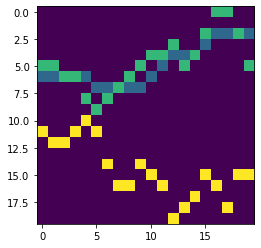

In [9]:
          plt.imshow(blank_matrix)
          plt.show()

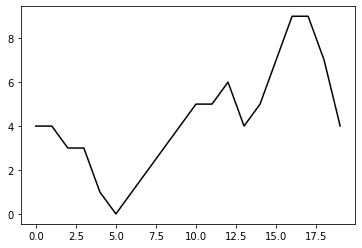

In [10]:
          plt.plot(graph_close, color='black')
          plt.show()

In [11]:
x_train[0].shape

(20, 20)

In [12]:
y_train[0]

1

In [26]:
x_live[0].shape

(20, 20)

In [18]:
####################################################################
# Run simple keras CNN model
####################################################################
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 32
num_classes = 2
epochs = 20

In [19]:
# input image dimensions
img_rows, img_cols = TIME_RANGE, PRICE_RANGE

In [20]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [21]:
# add fake depth channel 
x_train_mod = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_valid = x_valid.reshape(x_valid.shape[0], img_rows, img_cols, 1)
input_shape = (TIME_RANGE, PRICE_RANGE, 1)

x_train_mod = x_train_mod.astype('float32')
x_valid = x_valid.astype('float32')

print('x_train_mod shape:', x_train_mod.shape)
print('x_valid shape:', x_valid.shape)
 
y_train_mod = tf.keras.utils.to_categorical(y_train, num_classes)
y_valid_mod = tf.keras.utils.to_categorical(y_valid, num_classes)
print('y_train_mod shape:', y_train_mod.shape)
print('y_valid_mod shape:', y_valid_mod.shape)

x_train_mod shape: (5942, 20, 20, 1)
x_valid shape: (500, 20, 20, 1)
y_train_mod shape: (5942, 2)
y_valid_mod shape: (500, 2)


In [22]:
model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(10, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 10)        1290      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 10)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 6, 6, 10)          0         
                                                                 
 flatten (Flatten)           (None, 360)               0         
                                                        

In [23]:
model.fit(x_train_mod, y_train_mod,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_train_mod, y_train_mod))
score = model.evaluate(x_train_mod, y_train_mod, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
predictions = model.predict(x_valid)
# run an accuracy or auc test
from sklearn.metrics import roc_curve, auc, accuracy_score
 
# balance
print('balance', np.mean(y_train_mod[:,1]))

#print('Model accuracy: ', accuracy_score(y_valid_mod[:,1], temp_predictions,'%'))
fpr, tpr, thresholds = roc_curve(y_valid_mod[:,1], predictions[:,1])
roc_auc = auc(fpr, tpr)
print('valid auc:', roc_auc)

actuals = y_valid_mod[:,1]
preds = predictions[:,1]
from sklearn.metrics import accuracy_score
print ('Accuracy on all data:', accuracy_score(actuals, [1 if x>=0.5 else 0 for x in preds]))

Epoch 1/20
186/186 [==============================] - 12s 61ms/step - loss: 0.6910 - accuracy: 0.5266 - val_loss: 0.6918 - val_accuracy: 0.5283
Epoch 2/20
186/186 [==============================] - 11s 62ms/step - loss: 0.6767 - accuracy: 0.5740 - val_loss: 0.6584 - val_accuracy: 0.6207
Epoch 3/20
186/186 [==============================] - 13s 72ms/step - loss: 0.6554 - accuracy: 0.6116 - val_loss: 0.6233 - val_accuracy: 0.6484
Epoch 4/20
186/186 [==============================] - 16s 87ms/step - loss: 0.6194 - accuracy: 0.6550 - val_loss: 0.5657 - val_accuracy: 0.7183
Epoch 5/20
186/186 [==============================] - 11s 59ms/step - loss: 0.5864 - accuracy: 0.6878 - val_loss: 0.5144 - val_accuracy: 0.7585
Epoch 6/20
186/186 [==============================] - 10s 55ms/step - loss: 0.5439 - accuracy: 0.7211 - val_loss: 0.4500 - val_accuracy: 0.8075
Epoch 7/20
186/186 [==============================] - 11s 59ms/step - loss: 0.4837 - accuracy: 0.7639 - val_loss: 0.3826 - val_accuracy:

In [28]:
####################################################################
# Play around with thresholds to pick the best predictions
####################################################################

# pick top of class to find best bets 
actuals = y_valid_mod[:,1]
preds = predictions[:,1]
from sklearn.metrics import accuracy_score
print ('Accuracy on all data:', accuracy_score(actuals,[1 if x >= 0.5 else 0 for x in preds]))
 
threshold = 0.75
preds = predictions[:,1][predictions[:,1] >= threshold]
actuals = y_valid_mod[:,1][predictions[:,1] >= threshold]
from sklearn.metrics import accuracy_score
print ('Accuracy on higher threshold:', accuracy_score(actuals,[1 if x > 0.5 else 0 for x in preds]))
print('Returns:',len(actuals))

Accuracy on all data: 0.488
Accuracy on higher threshold: 0.5082872928176796
Returns: 181


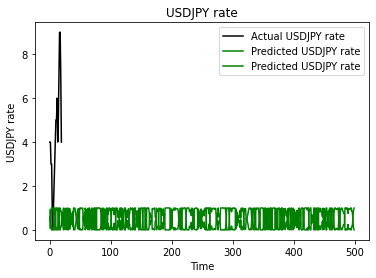

In [30]:
plt.plot(graph_close, color='black', label =f'Actual USDJPY rate')
plt.plot(predictions, color='green', label=f"Predicted USDJPY rate")
plt.title(f"USDJPY rate")
plt.xlabel('Time')
plt.ylabel(f'USDJPY rate')
plt.legend()
plt.show()